# Trees

In [15]:
!pip install PyGraphviz

  Using cached https://files.pythonhosted.org/packages/3a/d6/2c56f09ee83dbebb62c40487e4c972135661b9984fec9b30b77fb497090c/pygraphviz-1.7.zip
  ERROR: Failed building wheel for PyGraphviz
  Running setup.py clean for PyGraphviz
Failed to build PyGraphviz
    Running setup.py install for PyGraphviz ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-ld255w1h/PyGraphviz/setup.py'"'"'; __file__='"'"'/tmp/pip-install-ld255w1h/PyGraphviz/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-vi6myvdo/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.


In [ ]:
!pip install biopython

In [13]:
import matplotlib
import networkx
import pydot
import pylab

In [1]:
#Node
class Node(object):
    def __init__(self,anc,bl=1):
        self.ancestor=anc                   # ancestor Node
        self.children=[]                    # children Nodes
        self.branch=bl                      # branch length of branch leading to actual node
        self.name=""                        # name of node, eg. taxa name
        self.depth=len(self.ancestors())-1  # depth of Node, root has depth 0

    def set_child(self,child): self.children.append(child) #append child to list

    def ancestors(self): #return ancestor nodes and self node in order root->bottom
        if self.ancestor==None: return [self.name]
        else: return self.ancestor.ancestors()+[self.name]

    def traverse(self): #returns self node + children traversing
        trav = [self]
        for child in self.children:
            trav+=child.traverse()
        return trav

    def get_leaves(self): #returns list of leaves under node
        if len(self.children)==0:return [self.name]
        l=[]
        for child in self.children:
            l+=child.get_leaves()
        return l       

    def newick(self,intern=False,bl=False): #creates newick string from tree
        if len(self.children)==0:
            if bl: return "%s:%f" %(self.name,self.branch)
            else: return self.name
        s="("+self.children[0].newick(intern,bl)
        for i in range(1,len(self.children)):
            s+=","+self.children[i].newick(intern,bl)
        s+=')'
        if self.ancestor==None:return s
        if intern:s+=self.name
        if bl:s+=":%f" %self.branch
        return s


    def __split_representation(self,all_leaves,act_leaves): #+/- representation which splits are present
        n=len(all_leaves)
        act_string=''
        for i in range (0,n):
            if (all_leaves[i] in act_leaves):act_string+='+'
            else: act_string+='-'
        return act_string
    
    def decomposition(self,other): #create decompositions on common edges of self and other --> returns list of pairs
        all_trees=[[self,other]]
        nodedic={}
        all_leaves=self.get_leaves()
        all_leaves.sort()
        n=len(all_leaves)
        count=1
        taxadic={}
        
        for node in other.traverse():
            act_leaves=set(node.get_leaves())
            nodedic[self.__split_representation(all_leaves,act_leaves)]=node
        for node in self.traverse():
            act_leaves=set(node.get_leaves())
            if len(act_leaves)==n or len(act_leaves)==1:continue
            act_string=self.__split_representation(all_leaves,act_leaves)
            if act_string in nodedic:
                othernode=nodedic[act_string]
                otherchild=set(othernode.children[0].get_leaves())
                distinct=True
                for child in node.children: #are only 2
                    if set(child.get_leaves())==otherchild:distinct=False
                    
                if distinct: #decompose!
                    newroots=[]
                    taxa=node.get_leaves()
                    taxa.sort()
                    taxadic["d%i"%count]=taxa
                    othert=list(set(all_leaves).difference(set(taxa)))
                    othert.sort
                    taxadic["d%i"%(count+1)]=othert
                    
                    for act_node in node,othernode:
                        
                        newnode=Node(act_node.ancestor,act_node.branch)
                        newnode.name="d%i"%count #dummy node
                        ac=act_node.ancestor.children
                        change=0
                        if ac[1]==act_node:change=1
                        ac[change]=newnode

                        act_node.branch=0
                        newroot=Node(None,0)
                        newroot.name='root'
                        newroot.set_child(act_node)
                        newnode=Node(newroot,0)
                        newnode.name="d%i"%(count+1)
                        newroot.set_child(newnode)
                        act_node.ancestor=newroot
                        newroots.append(newroot)
                    count+=2
                    
                    all_trees.append(newroots)
        return taxadic,all_trees

    def get_bl(self,term=True): #return branch lengths list
        bl=[]
        for node in self.traverse():
            if not node.ancestor:continue
            if not term and len(node.children)==0:continue
            bl.append(node.branch)
        return bl

    def get_graph(self): #only topology, returns adjacency matrix
        nodes=self.traverse()
        num=len(nodes)
        
        leaves=nodes[0].get_leaves()
        splits=[nodes[0].__split_representation(leaves,leaves)]
        namedic={nodes[0].name:0}
        
        adj=[]
        for i in range(0,num):
            adj.append([0]*num)
        for i in range(1,num):
            anc=nodes[i].ancestor
            adj[i][namedic[anc.name]]=1;adj[namedic[anc.name]][i]=1;
            for c in anc.children:
                if c.name in namedic: adj[i][namedic[c.name]]=1;adj[namedic[c.name]][i]=1; #else it is set when brother is processed
            splits.append(nodes[i].__split_representation(leaves,nodes[i].get_leaves()))
            namedic[nodes[i].name]=i
        return adj,splits,leaves
            


In [46]:
!pip install networkx==2.3b

     |████████████████████████████████| 1.8MB 8.0MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556408 sha256=305afbdd31a5943ad9b92b6d640dcf1c88f1af31e1fea86ea70ec52c5a8c92b7
  Stored in directory: /root/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Successfully built networkx
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: networkx 2.5
    Uninstalling networkx-2.5:
      Successfully uninstalled networkx-2.5


In [5]:
from Bio import Phylo

In [31]:
trees = Phylo.parse('example.trees', 'newick')

In [30]:
for tr in trees:
  print(tr)

Tree(rooted=False, weight=1.0)
    Clade()
        Clade(branch_length=0.7)
            Clade(branch_length=0.6)
                Clade(branch_length=0.1, name='A')
                Clade(branch_length=0.2, name='B')
            Clade(branch_length=0.1, name='C')
        Clade(branch_length=0.3, name='D')
        Clade(branch_length=0.5)
            Clade(branch_length=0.3, name='E')
            Clade(branch_length=0.4, name='F')
Tree(rooted=False, weight=1.0)
    Clade()
        Clade(branch_length=0.6)
            Clade(branch_length=0.5)
                Clade(branch_length=0.1, name='A')
                Clade(branch_length=0.2, name='C')
            Clade(branch_length=0.1, name='B')
        Clade(branch_length=0.3, name='E')
        Clade(branch_length=0.7)
            Clade(branch_length=0.3, name='D')
            Clade(branch_length=0.4, name='F')
Tree(rooted=False, weight=1.0)
    Clade()
        Clade(branch_length=0.7)
            Clade(branch_length=0.6)
                Clade(b

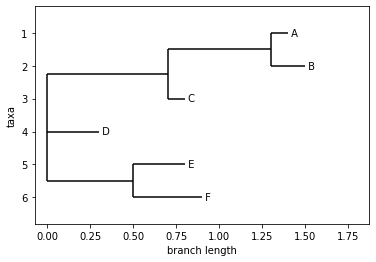

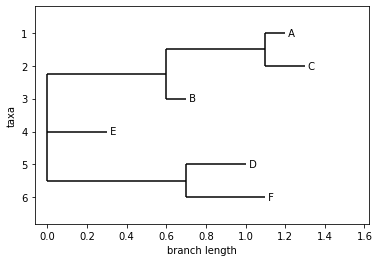

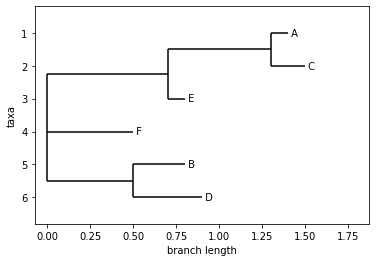

In [32]:
for tr in trees:
  Phylo.draw(tr)

# Geodesics
Based on experiments from this paper: https://pubmed.ncbi.nlm.nih.gov/18631022/?fbclid=IwAR2BwYWbapHNCrU7rXroZC1-4wozzjFvmKbbQ1hG8HX6kA1uAYt36UeWGq4

In [35]:
#http://www.cibiv.at/software/geometree/GeoMeTree.pdf?fbclid=IwAR19_UbN-Es970DLQ232S7MJ6oOv1OhhjpTF3jRqswg3jaSWPb_1FHSKcdY
#Utils
from string import *
import math

#================================================================================#
# Functions for Norm ...

def snorm(c): #squared norm
    n=0
    for i in c:
        n+=i**2        
    return n

def norm(c):return math.sqrt(snorm(c))


#================================================================================#
# Functions for Distance Computation
def eucl(c):
    sum=0
    for i in range(0,len(c[0])):
        sum+=(c[0][i]-c[1][i])**2
    return math.sqrt(sum)

def coordinates(r_equ,l_equ,s): #get coordinates for the equations at point s
    p=[]
    for e in l_equ:
        x=0
        if e[0]==-1 or e[0]>=s:x=e[1]*s+e[2]
        if abs(x)<1e-10:x=0
        p.append(x)
    for e in r_equ:
        x=0
        if e[0]!=-1 and e[0]<=s:x=e[1]*s+e[2]
        if abs(x)<1e-10:x=0
        p.append(x)
    return p


def dist_for_geod(r_equ,l_equ,slist=[]):

    def extract_s_from_equ(r_equ,l_equ):
        s=set([0,1])
        for equ in r_equ,l_equ:
            for e in equ:
                if e[0]==-1:continue
                s.add(e[0])
        return sorted(list(s))
    
    if len(slist)==0:slist=extract_s_from_equ(r_equ,l_equ)
    p0=coordinates(r_equ,l_equ,slist[0])
    dist=[]
    for i in range(1,len(slist)):
        p1=coordinates(r_equ,l_equ,slist[i])
        dist.append(eucl([p0,p1]))
        p0=p1
    return dist

def equations(s,bl1,bl2,dec=""): #create right and left equations for all splits

    if not dec: splits=list(bl1.keys())
    else: splits=[i for i in list(bl1.keys()) if i.startswith("%s/"%dec)]
    
    only1=[]; only2=[]; both=[]
    for sp in splits:
        if bl1[sp]==0:only2.append(sp)
        elif bl2[sp]==0:only1.append(sp)
        else:both.append(sp)
    only1.sort(); only2.sort(); both.sort() #the splits lists
    
    ttimes={}.fromkeys(splits)
    for t in list(s.keys()):
        for l in s[t]: #pair of left and right split lists
            for j in l: #all splits in that split list
                ttimes[str(j)]=t
    
    l_equ=[[ttimes[i],-bl1[i]/ttimes[i],bl1[i]] for i in only1]
    
    r_equ=[[ttimes[i],bl2[i]/(1-ttimes[i]),bl2[i]-bl2[i]/(1-ttimes[i])] for i in only2]
    r_equ+=[[0,bl2[i]-bl1[i],bl1[i]] for i in both]
    
    return [l_equ,r_equ],only1+only2+both
    
   

#================================================================================#
# Functions for Indexing ...

def index(plist,dim):

    def binomial(n, k):
        if k==0:return 1
        if 2*k>n:return binomial(n,n-k)
        r=n
        for i in range(2,k+1):
            r*=(n+1-i)
            r/=i
        return r
    
    def binomialsum(n,k): # \sum_{i=0}^{k} (n choose i)
        if k==-1:return 0
        s=1
        p=1
        for i in range(0,k):
            p *= (n-i)/float(i+1)
            s+=p
        return int(round(s))
    
    def binomialsum2(n,k,a): #\sum_{i=1}^{k} (n-i choose a)
        s=0
        for i in range(1,k+1):
            s+=binomial(n-i,a)
        return s

    def index2(plist,dim):
        k=len(plist)
        if k==0: return 0
        min=plist.pop(0)
        s=binomialsum2(dim,min,k-1)
        return s+index2(list(map(lambda x,z=1+min:x-z,plist)),dim-min-1) #reduce plist by min+1


    k=len(plist)
    start=binomialsum(dim,k-1)
    return start+index2(plist,dim)

#================================================================================#
# Functions for Sets ...

def int_to_list(n,dim):
    s=[]
    for i in range(0,dim):
        if n & (1<<i) : s.append(i)
    return s

def int_to_set(n,dim):
    return set(int_to_list(n,dim))

def set_to_int(s):
    n=0
    for i in s:
        n|=1<<i
    return n

#================================================================================#
# Functions for Input ...

def parse_newick(newick_string):
    root=Node(None)
    root.branch=0
    root.name='root'
    ancnode=None
    actnode=root
    bl,name=False,False
    i=1
    for char in newick_string:
        if bl:
            if char==')' or char==',':
                actnode.branch=float(branch)
                bl=False
            else:
                branch+=char
                continue
        elif name:
            if char==')' or char==',' or char=='(' or char==":":
                if len(namestr)==0:
                    namestr="inner_%u"%i
                    i+=1
                actnode.name=namestr
                name=False
            else:
                namestr+=char
                continue
            
        if char=='(':ancnode=actnode
        if char=='(' or char==',':
            actnode=Node(ancnode) #New node
            ancnode.set_child(actnode)
            namestr=""
            name=True
        elif char==')':
            actnode=ancnode
            ancnode=actnode.ancestor
        elif char==':':
            bl=True
            branch=""
    return root

def splits_for_tree(root,term): #Creates split-list,bl-list, boolean poly (True if multifurcations or zero branch lengths), n (number of spp)
    all_leaves=root.get_leaves()
    all_leaves.sort()
    set_leaves=set(all_leaves)
    n=len(all_leaves) #number of taxa
    splits={} #save splits with branch length in dictionary

    for node in root.traverse():
        act_leaves=node.get_leaves()
        act_l=len(act_leaves)
        if act_l==n:continue
        if node.branch==0:continue #do not collect zero-branch-lengths
        if not term and act_l==1:continue
        act_leaves.sort()
        other_leaves=list(set_leaves.difference(set(act_leaves)))
        other_leaves.sort()
        s1=act_leaves[0]
        for i in range (1,act_l):
            s1+="*%s"%act_leaves[i]
        s2=other_leaves[0]
        for i in range (1,n-act_l):
            s2+="*%s"%other_leaves[i]
        if s1<s2:s="%s|%s"%(s1,s2)
        else:s="%s|%s"%(s2,s1)
        if s in splits:splits[s]+=node.branch #root splits one branch
        else:splits[s]=node.branch
    
    split_list=list(splits.keys())
    split_list.sort()
    bl=[splits[s] for s in split_list]
    return split_list,bl,n

#================================================================================#
# Functions for Output ...

def path_to_str(s,L=[],R=[]): #three Lists or s-dictionary
    if type(s)==dict:
        new_s=list(s.keys());new_s.sort()
        L=[];R=[]
        for i in new_s:
            L+=[s[i][0]]
            R+=[s[i][1]]
        s=new_s
    out="t\tL\tR\n"
    for i in range(0,len(s)):
        if not L[i]:L[i]='-'
        if not R[i]:R[i]='-'
        out+="%1.6f\t%s\t%s\n"%(s[i],"*".join([str(j) for j in L[i]]),"*".join([str(j) for j in R[i]]))
    return out

def ind_trans_points(times,r_equ,l_equ):
    out=""
    for t in times:
        out+="g(%1.4f) = ( %s )\n" %(t,", ".join(["%1.4f"%i for i in coordinates(r_equ,l_equ,t)]))

    return out

def trans_points(s,bl1,bl2,dec=""): #three dictionaries, if dec set, then only results for one decomposition
    equ,spl=equations(s,bl1,bl2,dec)
    out="Splits:     ("
    for sp in spl:
        out+="%s%s,"%(" "*(7-len(sp)),sp)
    out=out[:-1]+" )\n"

    l_equ,r_equ=equ
    times=list(s.keys());times.sort()
    return out+ind_trans_points(times,r_equ,l_equ)

def shorter_split(long_split):
    splt=long_split.split("|")
    k,l=splt[0].count("*"),splt[1].count("*")
    if l<k: return splt[1]
    else: return splt[0]  

#================================================================================#


In [3]:
#Graph
from copy import *

#================================================================================#
# Classes for the Graph 

class Path: #goes from 1 to 0!
    def __init__(self,edgelist):
        self.edges=edgelist
        self.__inverse=False

    def equations(self,bl1,bl2):
        r_equ=[]
        l_equ=[]
        for e in self.edges:
            act_l,act_r=e.get_equations(bl1,bl2)
            l_equ+=act_l
            r_equ+=act_r
        return (l_equ,r_equ)

    def distance_old(self,bl1,bl2,final=1): #compute distance for path and given branch lengths

        l_equ,r_equ=self.equations(bl1,bl2)
       
        slist=[e.s for e in self.edges]
        slist.reverse() #reverse should not change distance computation
        if slist[-1]!=final:slist.append(final)
        dist=[]
        p0=coordinates(r_equ,l_equ,0)
        for s in slist:
            p1=coordinates(r_equ,l_equ,s)
            dist.append(eucl([p0,p1]))
            p0=p1
            
        return dist

    def distance(self,bl1,bl2): #dont need branch lengths any more!
        dlist=[e.dist for e in self.edges]
        return [norm(dlist)]

    def get_L(self):
        if not self.__inverse:
            llist=[int_to_list(e.L,Orthant.dim1) for e in self.edges]+[[]] 
            llist.reverse()
        else:llist=[int_to_list(e.R,Orthant.dim2) for e in self.edges]+[[]]
        return llist
    
    def get_R(self):
        if not self.__inverse:
            rlist=[int_to_list(e.R,Orthant.dim2) for e in self.edges]+[[]]
            rlist.reverse()
        else:rlist=[int_to_list(e.L,Orthant.dim1) for e in self.edges]+[[]]
        return rlist
    
    def get_s(self):
        if not self.__inverse:
            slist=[e.s for e in self.edges]+[0]
            slist.reverse()
        else:slist=[1-e.s for e in self.edges]+[1]
        return slist

    def __repr__(self):return str(self.edges)

    def inverse(self):
        self.__inverse= not self.__inverse

#================================================================================#

class IEdge: #Representation of an edge
    def __init__(self,Neg,todoPos,L,R,anc=None,s=-1):
        self.anc=anc #ancestor orthant
        self.s=s     #transition time
        self.dist=0  #distance of edge in subtreespace
        self.L=L     #list of Left indices
        self.R=R     #list of Right indices

        Neg=self.__verify(Neg)            #create new Neg-set
        todoPos=self.__adapt(Neg,todoPos) #create new todoPos-set
        self.__compute_id(todoPos)        #compute id of orthant at tip of edge, and save it in the list for future processing, stores id of orthant in self.__id

    def __verify(self,Neg): #adapt L with Coordinates necc to shrink

        def is_right_list_compatible(s,l,adj): # s has to be compatible with every split in l
            for split in l:
                if not adj[s][split]:return False
            return True

        Rs=int_to_list(self.R,Orthant.dim2)
        for n in int_to_list(Neg,Orthant.dim1):
            if not is_right_list_compatible(n,Rs,Orthant.adj):
                self.L+=1<<n
                
        return self.anc.Neg-self.L
        
    def __adapt(self,Neg,todo): #coordinates which can be expanded

        def is_left_list_compatible(s,l,adj): # s has to be compatible with every split in l
            for split in l:
                if not adj[split][s]:return False
            return True
        
        Ns=int_to_list(Neg,Orthant.dim1)
        for p in int_to_list(todo,Orthant.dim2): 
            if is_left_list_compatible(p,Ns,Orthant.adj):
                self.R+=1<<p
        return self.anc.todo-self.R
        
    def __compute_id(self,todo): #compute unique id from todo-pattern
        max=2**(Orthant.dim2+1) - 1
        simple_id=max^todo #xor, is the difference
        if simple_id in Orthant.IDList:self.__id=Orthant.IDList[simple_id]
        else:
            plist=int_to_list(simple_id,Orthant.dim2)
            self.__id=index(plist,Orthant.dim2)
            Orthant.IDList[simple_id]=self.__id

            
    def compute_s(self,bl1,bl2,orth): #Computation of transition times t, need orthant for optimization
        global opts
        if self.s!=-1:return True  #first node has no ancestor, s already 0
        
        nl=norm([bl1[i] for i in int_to_list(self.L,Orthant.dim1)])
        nr=norm([bl2[i] for i in int_to_list(self.R,Orthant.dim2)])

        self.dist=nl+nr
        self.s=nl/self.dist
        
        if self.anc.edges and self.s <= min([e.s for e in self.anc.edges]): return False #no valid joining point
        
        if not Orthant.opt:return True
        
        if orth.todo==0:return True
        nl=norm([bl1[i] for i in int_to_list(orth.Neg,Orthant.dim1)])
        nr=norm([bl2[i] for i in int_to_list(orth.todo,Orthant.dim2)])
        if self.s > nl/(nl+nr):return False
        
        return True


    def get_id(self):return self.__id

    def create_orthant(self):
        Neg=self.anc.Neg-self.L
        todoPos=self.anc.todo-self.R
        return Orthant(Neg,todoPos,self)

        
    def __eq__(self,other): return (self.__id==other.__id) and (self.anc==other.anc) #same edge, if same id and same ancestor
    
    def __repr__(self):return  "(L: "+str(int_to_set(self.L,Orthant.dim1))+" R: "+str(int_to_set(self.R,Orthant.dim2))+" t:  "+str(self.s)+")" #string representation
    
    def __create_equations(self,bl1,bl2): #create equations from transition times, L and R and branch lengths
        l_equ=[]
        for i in int_to_list(self.L,Orthant.dim1):
            l_equ.append([self.s,-bl1[i]/self.s,bl1[i]])
        r_equ=[]
        for i in int_to_list(self.R,Orthant.dim2):
            r_equ.append([self.s,bl2[i]/(1-self.s),bl2[i]-bl2[i]/(1-self.s)])
        return (l_equ,r_equ)

    def get_equations(self,bl1,bl2): #return equations
        return self.__create_equations(bl1,bl2)

#================================================================================#

#Orthant class variables: dim1, dim2, IDList, adj
class Orthant(object):
    def __init__(self,Neg,todoPos,edge=None):
       if edge: 
           self.edges=[edge]        #list of ingoing edges
           self.__id=edge.get_id()  #id already computed
       else:
           self.edges=[]            #first orthant has no ingoing edge
           self.__id=0

       if type(Neg)==set:Neg=set_to_int(Neg)
       self.Neg=Neg                 #set of indices from T1
       if type(todoPos)==set:todoPos=set_to_int(todoPos)
       self.todo=todoPos            #set of indices from T2 not yet processed

    def __repr__(self):return "Splits from T1: "+str(int_to_set(self.Neg,Orthant.dim1))+" Splits from T2 Todo: "+str(int_to_set(self.todo,Orthant.dim2))+" ID: "+str(self.__id) #string representation    

    def __hash__(self):return self.__id #order of orthants

    def __cmp__(self,other):return self.__id-other.__id #an orthant is smaller if it has smaller id

    def get_id(self):return self.__id

    def get_todo(self):return int_to_set(self.todo,Orthant.dim2)
    
    def clone(self,c): #create new edge starting in orthant where c is changed to pos
        cint=set_to_int(c)
        return IEdge(Neg=self.Neg,todoPos=self.todo-cint,anc=self,L=0,R=cint)
        
#================================================================================#


In [34]:

# external libraries
from string import *
from copy import *
import sys
import math
import time

'''
def parse_options():

    from optparse import OptionParser, OptionGroup, SUPPRESS_HELP
    parser = OptionParser()
    group=OptionGroup(parser,"Input options")
    group.add_option("-f", "--file", dest="infile", help="Name of input file, all pairs of trees in the file are evaluated (no default!)",default=None)
    parser.add_option_group(group)

    group=OptionGroup(parser,"Tree lengths options")
    group.add_option("-n", "--norm", dest="normalize",help="Normalize the branch length vectors to norm 1 (default: no normalization)",action="store_true",default=False)
    group.add_option("-t", "--term",dest="term",help="Ignore branch lengths of terminal splits (then also ignored in normalization, default: terminal branch lengths considered)",action="store_false",default=True)
    parser.add_option_group(group)

    group=OptionGroup(parser,"Algorithmic options")
    group.add_option("-o","--opt",dest="opt",action="store_false",default=True,help=SUPPRESS_HELP) #help="Turn off optimization (default: with optimization)"
    group.add_option("-g","--graph",dest="graph",help=SUPPRESS_HELP,action="store_false",default=True) #help="Turn off evaluation of complete graph (default: on)"
    group.add_option("-a","--approx",dest="approx",help="Compute only the approximations, not geodesic path",action="store_true",default=False)
    group.add_option("-d","--decomp",dest="decomp",help="Do not decompose the trees (default: decomposition when possible)",action="store_false",default=True)
    parser.add_option_group(group)

    group=OptionGroup(parser,"Output options") 
    group.add_option("-m","--name",dest="outfile",default="None",help=SUPPRESS_HELP)#,help="Name of tabular output file, if 0: {file}.dist, default None"
    group.add_option("-s","--silent",dest="silent",help=SUPPRESS_HELP,action="store_true",default=False) #no pair file
    group.add_option("-v","--header",dest="header",help="Header name of output file(s) (default: 'pair', then files pair_i_j are generated for each pair)",default="pair")
    parser.add_option_group(group)

    (options, args) = parser.parse_args()
    
    if not options.infile:
        print("\nName of infile required (option -f)\n")
        parser.print_help()
        sys.exit(0)

    if options.approx:options.graph=False #suppresses output for graph
        
    return options

'''

#================================================================================#  
# Methods for parsing newick trees
#================================================================================#  

def get_splits(newick_string,term=False): #if term: append also terminal splits and branch lengths    
    return splits_for_tree(parse_newick(newick_string),term)

def get_splits_with_decomposition(newick1,newick2,term=False): #if term: append also terminal splits and branch lengths
    global opts
    
    root1=parse_newick(newick1)
    root2=parse_newick(newick2)

    
    taxad,decomp=root1.decomposition(root2) #returns taxa-dictionary of dummy taxa and decompositions as pairs of root nodes

    all_splits=[] #stores pairs of subtrees to be compared

    for droot1,droot2 in decomp:
        act_splits=[]

        for droot in droot1,droot2:
            act_splits.append(list(splits_for_tree(droot,term)))
        all_splits.append(act_splits)
                
    return taxad,all_splits

def get_split_representation(splits1,splits2): #extract splits only in one tree and compute adjacency matrix
    
    def is_compatible(s1,s2):
        s1r,s1l=s1.split('|') #right and left side
        s2r,s2l=s2.split('|')
        for i in s1r,s1l:
            act1=set(i.split('*'))
            for j in s2r,s2l:
                act2=set(j.split('*')) 
                if len(act1.intersection(act2))==0:return True
        return False

    splits1s=set(splits1).difference(set(splits2)) #splits only in T1
    splits2s=set(splits2).difference(set(splits1)) #splits only in T2

    splits=list(splits1s)+list(splits2s) #now the splits are only those which occur in Exactly one tree, the first dim1 are from T1 and the last dim2 are from T2
    
    dim1=len(splits1s)
    dim2=len(splits2s)
    
    adj=[]
    for i in range(0,dim1):
        adj.append([False]*dim2)
        
    for i in range(0,dim1):
        for j in range(0,dim2):
            c=is_compatible(splits[i],splits[dim1+j])
            adj[i][j]=c
    
    return splits, adj, len(splits1s), len(splits2s)


#================================================================================#  
#Methods for finding the geodesic path
#================================================================================#  

def geodesic(adj,bl1,bl2,neg,todo): #returns the last orthant
    global opts

    bestp=[None]
    mind=[cone(bl1,bl2)+1]
    countp=[0]
    
    def best_path(edge,past=[]): #finds shortest path through graph
        past.append(edge)
        if not edge.anc.edges:
            countp[0]+=1
            newp=Path(past)
            dist=newp.distance(bl1,bl2)
            if sum(dist)<mind[0]:
                mind[0]=sum(dist)
                bestp[0]=newp
        for e in edge.anc.edges:
            if e.s < past[-1].s:best_path(e,deepcopy(past))
            
    def one_path(edge):
        elist=[edge]
        while edge.anc.edges:
            edge=edge.anc.edges[0]
            elist.append(edge)
        return Path(elist)

    def next_sub(str,i): return [x for (pos,x) in zip(list(range(len(str))), str) if (2**pos) & i] #enumerate all 2**str subsets by binary numbers

    #set class variables
    Orthant.opt=opts.opt
    Orthant.dim1=len(bl1)
    Orthant.dim2=len(bl2)
    Orthant.adj=adj

    length=2**Orthant.dim2  #number of indices generated for the orthants
    Orthant.OrthList=[None]*length

    ###Orthant.IDList=[-1]*length #stores mapping of simple IDs (binary numbers) to complex IDs (binomial coefficients)
    Orthant.IDList={}
    
    start=Orthant(Neg=neg,todoPos=todo)
    startid=start.get_id()
    Orthant.OrthList[startid]=start

    max_i=0 #index of last orthant

    for i in range(startid,length):
        if not Orthant.OrthList[i]:continue #many orthants are not generated bec suborthants of a larger one
        max_i=i
        orth=Orthant.OrthList[i]

        actdim=len(orth.get_todo())
    
        for j in range(1,2**actdim): #0. Subset is empty
            switch=next_sub(orth.get_todo(),j) 
            newedge=orth.clone(switch) #switch is the initial R, the complete edge is generated in the constructor

            oid=newedge.get_id()
            oldorth=Orthant.OrthList[oid]
            if oldorth and oldorth.edges and (newedge in oldorth.edges):
                del newedge
                continue  #path already computed

            if not oldorth: #generate orthant where the edge points to
                neworth=newedge.create_orthant()
                succ=newedge.compute_s(bl1,bl2,neworth)
                if succ: Orthant.OrthList[oid]=neworth #may be not successfull, because transition times have to fullfill several constraints
                else:
                    del newedge
                    del neworth
                
            else:
                succ=newedge.compute_s(bl1,bl2,oldorth)
                if not succ:continue
                if opts.graph:oldorth.edges.append(newedge)
                else: 
                    oldedge=oldorth.edges[0]
                    maxsk=max(newedge.s,oldedge.s)
                    distdiff=sum(one_path(newedge).distance(bl1,bl2))-sum(one_path(oldedge).distance(bl1,bl2))
                    if distdiff<0: oldorth.edges=[newedge]
                    
    lastedge=IEdge(0,0,0,0,anc=Orthant.OrthList[max_i],s=1)
    best_path(lastedge)

    return bestp[0],countp[0]

    


#================================================================================#
#Methods for computing all the distances
#================================================================================#  

def cone(diff1,diff2,shared1=[],shared2=[]):
    sharednorm=snorm([shared1[i]-shared2[i] for i in range(0,len(shared1))])
    return math.sqrt((norm(diff1)+norm(diff2))**2+sharednorm)


def distance(tree1,tree2,outfile):
    global opts

    def permutation_indices(data): 
        return sorted(list(range(len(data))), key = data.__getitem__)

    def branch_score(diff1,diff2,shared1=[],shared2=[]):
        shared=[shared1[i]-shared2[i] for i in range(0,len(shared1))]
        return norm(diff1+diff2+shared)

    def combine(diff,shared,splits1,bl1,dstart,dend): #combine branch length lists so that indicees correspond to splits
        shared_branch=[bl1[splits1.index(s)] for s in shared]
        diff_branch=[bl1[splits1.index(diff[i])] for i in range (dstart,dend)]
        return diff_branch,shared_branch
        
    def create_shared_equ(branch1,branch2):
        equs=[]
        for i in range(0,len(branch1)):
            equs.append([0,branch2[i]-branch1[i],branch1[i]])
        return equs
    
    def inverse(mat):return [[mat[i][j] for i in range(0,len(mat))] for j in range(0,len(mat[0]))]

    #================================================================================#  

    outstring=""
    
    if opts.decomp:
        taxad,split_decomp=get_splits_with_decomposition(tree1,tree2,opts.term)
        if len(split_decomp)==1:
            header=False
            spp=split_decomp[0][0][2]
        else:
            header=True
            spp=get_splits(tree1,opts.term)[2]
    else:
        split_decomp=[[list(get_splits(tree1,opts.term)),list(get_splits(tree2,opts.term))]]
        header=False
        spp=split_decomp[0][0][2]
        
    all_equs=[]
    dec=1 #number of decomposition

    if outfile:
        outfile.write("Output of GeoMeTree v1.0\n\n")
        outfile.write("2 Trees of %u taxa given:\n"%spp)
        outfile.write("T1=%s\nT2=%s\n" %(tree1,tree2))
        if opts.normalize:outfile.write("\nTree vectors have been normalized to norm 1 !!!\n")
        if header:
            outfile.write("\nTrees have been decomposed at common splits, the following dummy taxa are used:\n")
            for t in sorted(taxad.keys()):
                outfile.write("%s\t%s\n" %(t,"*".join(taxad[t])))

    if opts.normalize:
        for j in [0,1]: #first and second tree
            bl=[]
            for s in split_decomp:
                bl+=s[j][1]
            n=norm(bl)
            for s in split_decomp:
                s[j][1]=[x/n for x in s[j][1]]

    s_dic={} #saves geodesic path in transition times and Left and Right sets
    bl_dic1={} #saves branch length of splits in case of multiple decompositions
    bl_dic2={}
    len_list=["cone","bs","geod","coneall","bsall","geodall"]
    split_list=["shared","diff1","diff2","dim"]
    len_dic={}.fromkeys(len_list) #save length and splits to compute overall numbers in the end
    for l in list(len_dic.keys()):
        len_dic[l]=[0]
    split_dic={}.fromkeys(split_list,0)
    graph=1
    compl_time=0

    for t1,t2 in split_decomp:
        splits1,bl1,spp1=t1
        splits2,bl2,spp2=t2
        new_s_dic={}
        
        # =============================================================================== #
        # creates set S (diff_splits), compatibility matrix (adj), C (shared_splits) and corresponding numbers
 
        diff_splits,adj,dim1,dim2=get_split_representation(splits1,splits2)
    
        shared_splits=list(set(splits1).intersection(set(splits2)))
        shared_splits.sort()
        c=len(shared_splits)
        overlap=set(splits1).intersection(splits2)

        # =============================================================================== #
        # combine branch length lists so that indices correspond to splits
        
        branch1_diff,branch1_shared=combine(diff_splits,shared_splits,splits1,bl1,0,dim1)
        branch2_diff,branch2_shared=combine(diff_splits,shared_splits,splits2,bl2,dim1,dim1+dim2)
    
        # =============================================================================== #
        # output

        outstring+="%u\t%u\t%u\t%u\t"%(spp1,len(overlap),len(branch1_diff),len(branch2_diff))
        split_dic["shared"]+=len(overlap)
        split_dic["diff1"]+=len(branch1_diff)
        split_dic["diff2"]+=len(branch2_diff)
 
        if outfile:
            outfile.write("\n%s\n"%('-'*80))
            if header:
                outfile.write ("\nResults for Decomposition No. %u:\n" %dec)

            outfile.write("\nSplits only in T1:\n")
            for i in range(0,dim1):
                splt=shorter_split(diff_splits[i])
                if header:outfile.write("%u/"%dec)
                outfile.write("%u\t%s\t%1.6f\n" %(i+1,splt,branch1_diff[i]))

            outfile.write("\nSplits only in T2:\n")
            for i in range(0,dim2):
                splt=shorter_split(diff_splits[dim1+i])
                if header:outfile.write("%u/"%dec)
                outfile.write("%u\t%s\t%1.6f\n" %(i+dim1+1,splt,branch2_diff[i]))    

            outfile.write("\nSplits common to both trees and branch length in T1 and T2:\n")
            for i in range (0,c):
                splt=shorter_split(shared_splits[i])
                if header:outfile.write("%u/"%dec)
                outfile.write("%u\t%s\t%1.6f\t%1.6f\n" %(i+dim1+dim2+1,splt,branch1_shared[i],branch2_shared[i]))
                
        # =============================================================================== #
        # fill bl_dics
        if header:
            for i in range(0,dim1):
                bl_dic1["%u/%u"%(dec,i+1)]=branch1_diff[i]
                bl_dic2["%u/%u"%(dec,i+1)]=0
            for i in range(0,dim2):
                bl_dic1["%u/%u"%(dec,dim1+i+1)]=0
                bl_dic2["%u/%u"%(dec,dim1+i+1)]=branch2_diff[i]
            for i in range (0,c):
                bl_dic1["%u/%u"%(dec,dim1+dim2+i+1)]=branch1_shared[i]
                bl_dic2["%u/%u"%(dec,dim1+dim2+i+1)]=branch2_shared[i]
        else:
            for i in range(0,dim1):
                bl_dic1[str(i+1)]=branch1_diff[i]
                bl_dic2[str(i+1)]=0
            for i in range(0,dim2):
                bl_dic1[str(dim1+i+1)]=0
                bl_dic2[str(dim1+i+1)]=branch2_diff[i]
            for i in range (0,c):
                bl_dic1[str(dim1+dim2+i+1)]=branch1_shared[i]
                bl_dic2[str(dim1+dim2+i+1)]=branch2_shared[i]
            
                
        # =============================================================================== #
        # there are different splits
    
        if dim1 or dim2:
            # =============================================================================== #
            # compute bounds          
            
            bs=branch_score(branch1_diff,branch2_diff) #lower bound
            ub=cone(branch1_diff,branch2_diff) #upper bound
            len_dic["cone"].append(ub)
            len_dic["bs"].append(bs)
            if opts.approx: #do not compute geodesic path
                if outfile:
                    outfile.write("\nResults for the different splits:\n")
                    #outfile.write("Branch score %1.6f\nCone distance %1.6f\n" %(bs,ub))
                outstring += "0\t%1.6f\t%1.6f\t0\t" %(bs,ub)
                count=0
                timeg=0
            else:
          
                # =============================================================================== #
                # find splits that are compatible to all others

                l_ind=[]
                #There may be some splits in the first tree that are compatible to all splits in the second tree -> they have to end at 1
                for i in range(0,dim1):
                    if adj[i]==[True]*dim2:l_ind.append(i)
                comp_equ_l=[[1,-branch1_diff[i],branch1_diff[i]] for i in l_ind]
                neg=set(range(0,dim1)).difference(set(l_ind))  #neg is the starting neg for the geodesic algorithm, in case of full compatibilities, some are excluded

                r_ind=[]
                #vice versa
                for j in range(0,dim2):
                    comp=True
                    for i in range(0,dim1):
                        if not adj[i][j]:
                            comp=False
                            break
                    if comp:r_ind.append(j)
                comp_equ_r=[[0,branch2_diff[i],0] for i in r_ind]
                todo=set(range(0,dim2)).difference(set(r_ind))        
        
                # =============================================================================== #
                # geodesic distance algorithm if still something todo

                t0=time.clock()
                if len(todo)>0: #it may be that all were compatible bec of polytomies

                    # =============================================================================== #
                    # todo should be the smaller set since algorithm is exponential in len(todo)
                    swap=(len(neg)<len(todo))
                    if swap:
                        adj=inverse(adj)
                        branch1_diff,branch2_diff=branch2_diff,branch1_diff
                        neg,todo=todo,neg
                    
                    outstring+="%u\t" %len(todo)
                    split_dic["dim"]+=len(todo)

                    try:
                        path,count=geodesic(adj,branch1_diff,branch2_diff,neg,todo)
                    except OverflowError:
                        print("To many splits in actual decomposition to compute the geodesic distance exactly:", Orthant.dim2)
                        print("Start the computation with option '-a' to compute the approximations")
                        continue
                    
                    t1=time.clock()
               
                    equ_l,equ_r= path.equations(branch1_diff,branch2_diff) #the assignment to first and second tree is not correct, but changes nothing for distance computation!!!
                    if swap:
                        branch1_diff,branch2_diff=branch2_diff,branch1_diff
                        path.inverse()
            
                else:
                    equ_l=[]
                    equ_r=[]
                    count=1
                    path=None
                    t1=t0
                    outstring+="0\t"

                # =============================================================================== #
                # Get the actual L, R and s and save in s_dic
                
                if path:
                    L = path.get_L();L=[[i+1 for i in l] for l in L]
                    R = path.get_R();R=[[i+dim1+1 for i in r] for r in R]
                    s = path.get_s()
                else:
                    L=[[],[]]
                    R=[[],[]]
                    s=[0,1]
                if r_ind: R[0]+=[i+dim1+1 for i in r_ind]
                if l_ind: L[-1]+=[i+1 for i in l_ind]    
                if header:
                    L=[["%u/%u"%(dec,i) for i in l] for l in L]
                    R=[["%u/%u"%(dec,i) for i in r] for r in R]
 
                for i in range(0,len(s)):
                   new_s_dic[s[i]]=[L[i],R[i]]


                # =============================================================================== #
                # Compute the distances for different splits and output them

                equ_l+=comp_equ_l
                equ_r+=comp_equ_r

                dist=dist_for_geod(equ_r,equ_l)
                timeg=t1-t0
                outstring+="%1.6f\t%1.6f\t%1.6f\t"%(bs,ub,sum(dist))

                    
                if outfile:
                    outfile.write("\nThe geodesic path:\n")
                    outfile.write(path_to_str(s,L,R))
                    if header:outfile.write("\nTransition points:\n%s\n"%trans_points(new_s_dic,bl_dic1,bl_dic2,dec))
                    else:outfile.write("\nTransition points:\n%s\n"%trans_points(new_s_dic,bl_dic1,bl_dic2))
                    outfile.write("\nResults for the different splits:\n")
                    outfile.write("Geodesic distance %1.6f\n" %(bs,sum(dist),ub))
                    
                len_dic["geod"].append(sum(dist))
            
        # =================================================================================== #
        # There are no different splits
        
        else:
            timeg=0
            equ_r=[];equ_l=[];count=1 #count is number of geodesic paths
            outstring+="0\t"*4
            new_s_dic[0]=[[],[]]
            new_s_dic[1]=[[],[]]
            if outfile:
                outfile.write("\nThe geodesic path:\nThere are no different splits, it equals the branch score.\n")
                if header:outfile.write("\nTransition points:\n%s\n"%trans_points(new_s_dic,bl_dic1,bl_dic2,dec))
                else:outfile.write("\nTransition points:\n%s\n"%trans_points(new_s_dic,bl_dic1,bl_dic2)) 

        # =============================================================================== #
        # Compute the distances for all splits and output them
        
        bs_compl=branch_score(branch1_diff,branch2_diff,branch1_shared,branch2_shared)
        cone_compl=cone(branch1_diff,branch2_diff,branch1_shared,branch2_shared)
        len_dic["coneall"].append(cone_compl)
        len_dic["bsall"].append(bs_compl)
        
        if opts.approx:
            outstring+="%1.6f\t%1.6f\t0\t0\t"%(bs_compl,cone_compl)
            if outfile:
                outfile.write("\nResults for all splits:\n")
                outfile.write("Branch score %1.6f\nCone distance %1.6f\n" %(bs_compl,cone_compl))

        else:
            dist_compl=dist_for_geod(equ_r+create_shared_equ(branch1_shared,branch2_shared),equ_l)
            outstring+="%1.6f\t%1.6f\t%1.6f\t%1.6f\t"%(bs_compl,cone_compl,sum(dist_compl),timeg)
            if opts.graph: outstring+="%u\t"%count
        
            if outfile:
                outfile.write("\nResults for all splits:\n")
                outfile.write("Geodesic distance %1.6f\n" %(bs_compl,sum(dist_compl),cone_compl))
                if opts.graph: outfile.write("\nComplete graph enumerated: %u path(s) found!\n" %count)
                outfile.write("\nComputation time for geodesic path: %1.4f s\n"%(timeg))

            len_dic["geodall"].append(sum(dist_compl))


        for s in list(new_s_dic.keys()):
            if s in s_dic:
                s_dic[s][0]+=new_s_dic[s][0]
                s_dic[s][1]+=new_s_dic[s][1]
            else: s_dic[s]=new_s_dic[s]
  
        compl_time+=timeg
        if opts.graph:graph*=count
        dec+=1

    #===============================================================================#
    #output in case of decompositions

    if header:
        for i in list(len_dic.keys()):
            len_dic[i]=norm(len_dic[i])
        outstring2=("%u\t"*5+"%1.6f\t"*7) %(spp,split_dic["shared"],split_dic["diff1"],split_dic["diff2"],split_dic["dim"],len_dic["bs"],len_dic["cone"],len_dic["geod"],len_dic["bsall"],len_dic["coneall"],len_dic["geodall"],compl_time)
        if opts.graph:outstring2+="%u\t"%graph
        outstring=outstring2+outstring
        
        if outfile:
            outfile.write("\n%s\n"%('-'*80))
            if not opts.approx:
                outfile.write("\nThe complete geodesic path:\n%s"%path_to_str(s_dic))
                outfile.write("\nTransition points:\n%s"%trans_points(s_dic,bl_dic1,bl_dic2))
            else:outfile.write("\nComplete results:\n")
            outfile.write("\nResults for the different splits:\n")
            outfile.write("Branch score %1.6f\n"%len_dic["bs"])
            if not opts.approx:outfile.write("Geodesic distance %1.6f\n"%len_dic["geod"])
            outfile.write("Decomposed cone distance %1.6f\n" %len_dic["cone"])
            outfile.write("\nResults for all splits:\n")
            outfile.write("Branch score %1.6f\n"%len_dic["bsall"])
            if not opts.approx:outfile.write("Geodesic distance %1.6f\n"%len_dic["geodall"])
            outfile.write("Decomposed cone distance %1.6f\n" %len_dic["coneall"])
            if opts.graph: outfile.write("\nComplete graphs enumerated: with independent decompositions %u path(s) found!\n" %graph)
            if not opts.approx:outfile.write("\nComputation time for all geodesic paths: %1.4f s\n"%(compl_time))
    return outstring

#===============================================================================#

def main():
    global opts
    #opts=parse_options()
    trees=open('example.trees').readlines()

    if opts.outfile=='None': outfile=None
    elif opts.outfile=='0': outfile=open(opts.infile+'.dist',"w")
    else: outfile=open(opts.outfile,'w')

    for i in range(0,len(trees)):
        for j in range(i+1,len(trees)):
            if opts.silent: actpair=None
            else: actpair=open("%s_%u_%u" %(opts.header,i+1,j+1),"w")
            outstr=distance(trees[i][:-1],trees[j][:-1],actpair)
            if outfile: outfile.write("%u\t%u\t%s\n"%(i+1,j+1,outstr))
            if actpair: actpair.close()
    if outfile: outfile.close()
    
if __name__ == "__main__":
  main()


NameError: ignored